In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [8]:
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df = pd.read_excel('股票客户流失.xlsx')

In [5]:
X = df.drop(columns=['是否流失'])
y = df['是否流失']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/opt/anaconda3/envs/tf-metal/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class weights: {0: 0.680763653939101, 1: 1.8830213903743316}
Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6729 - loss: 0.5840 - val_accuracy: 0.7353 - val_loss: 0.5368
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7022 - loss: 0.5672 - val_accuracy: 0.7459 - val_loss: 0.5214
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7157 - loss: 0.5613 - val_accuracy: 0.7438 - val_loss: 0.5149
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7206 - loss: 0.5592 - val_accuracy: 0.7431 - val_loss: 0.5178
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7196 - loss: 0.5521 - val_accuracy: 0.7459 - val_loss: 0.5096
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7249 - loss: 0.5531 - val_accuracy: 0.7438 - val_loss: 0.5154
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7201 - loss: 0.5559 - val_accuracy: 0.7424 - val_loss: 0.5193
Epoch 8/100
177/177 ━━━━━━━━━━━━━━

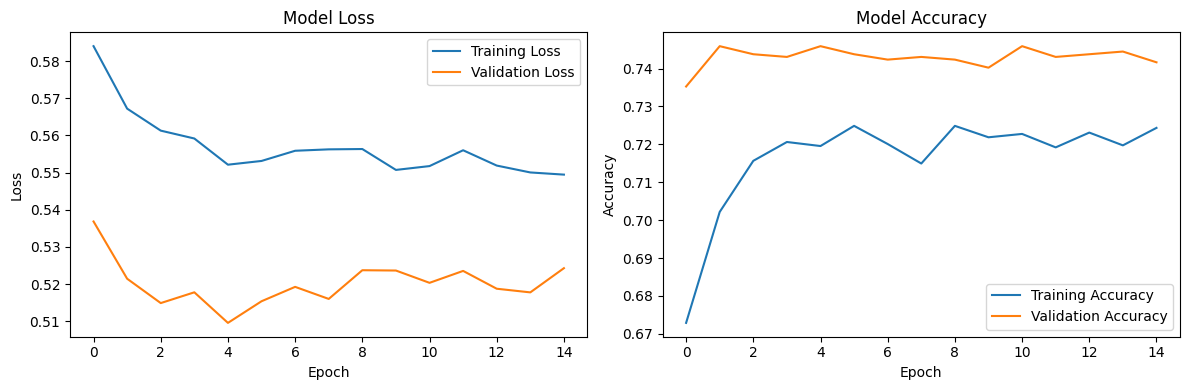

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_shape=(5,)),  # 第一层，32个神经元
    Dropout(0.3),                                   # 防止过拟合
    Dense(16, activation='relu'),                   # 第二层，16个神经元
    Dropout(0.3),
    Dense(1, activation='sigmoid')                  # 输出层，sigmoid用于二分类
])

# 编译模型
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',   # 二分类损失函数
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,           # 如果验证损失10轮不下降就停止
    restore_best_weights=True  # 恢复最佳权重
)

# 计算类别权重
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,            # 最多训练100轮
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,  # 使用类别权重
    verbose=1
)

y_pred_proba = model.predict(X_test_scaled).flatten()  # 预测概率
y_pred = (y_pred_proba > 0.5).astype(int)              # 转为0/1标签

print("=== 神经网络评估结果 ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

def calculate_ks(y_true, y_proba):
    data = np.column_stack([y_proba, y_true])
    sorted_data = data[data[:, 0].argsort()[::-1]]
    total_pos = np.sum(y_true == 1)
    total_neg = np.sum(y_true == 0)
    cum_pos = 0
    cum_neg = 0
    max_ks = 0
    for prob, label in sorted_data:
        if label == 1:
            cum_pos += 1
        else:
            cum_neg += 1
        tpr = cum_pos / total_pos
        fpr = cum_neg / total_neg
        ks = abs(tpr - fpr)
        if ks > max_ks:
            max_ks = ks
    return max_ks

ks_score = calculate_ks(y_test, y_pred_proba)
print("KS Score:", ks_score)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()